In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import shap

2025-06-18 04:46:51.016002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750222011.042838    4233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750222011.050853    4233 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750222011.072368    4233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750222011.072398    4233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750222011.072401    4233 computation_placer.cc:177] computation placer alr

In [2]:
plastic_waste = pd.read_csv('merged_plastic_bottle_waste.csv')
plastic_waste.head()

,product_barcode,product_label,product_size,brand_name,manufacturer_country,manufacturer_name,scan_country,data_url,bottle_weight,bottle_count
0,610696090768,Vimto Gasificado,350 ml,Vimto,GB,Nichols plc,MZ,https://wastebase.org/#/o/85022289-591b-4e34-9...,NaN,1
1,817939012079,Anti-Bac All Purpose Cleaner,828ml,Method,US,Method Products pbc,GB,https://wastebase.org/#/o/cb2a0f45-314c-4fd0-9...,NaN,1
2,2089616370071,Agua Mineral,5.0 L,Água de Namaacha,MZ,Sociedade de Águas de Moçambique,MZ,https://wastebase.org/#/o/90c9868b-d408-490e-b...,110.0,1
3,40822426,Bonaqua Mineral Water,500 ml,Bonaqua,US,Coca-Cola,MZ,https://wastebase.org/#/o/c3710738-2999-4396-a...,NaN,9
4,42380665,Fanta Litchi,280 ml,Fanta,US,Coca-Cola,MZ,https://wastebase.org/#/o/c3710738-2999-4396-a...,20.5,6


In [3]:
# Inspecting the size and (rows,columns) of the dataset
plastic_waste.shape

(87325, 10)

In [4]:
# Checking for null values in bottle_weight
plastic_waste['bottle_weight'].isnull().sum()

np.int64(83236)

In [5]:
# Removing unnecessary links and bottle_weight columns
plastic_waste = plastic_waste.drop(['data_url','bottle_weight'],axis=1)
plastic_waste.head()

,product_barcode,product_label,product_size,brand_name,manufacturer_country,manufacturer_name,scan_country,bottle_count
0,610696090768,Vimto Gasificado,350 ml,Vimto,GB,Nichols plc,MZ,1
1,817939012079,Anti-Bac All Purpose Cleaner,828ml,Method,US,Method Products pbc,GB,1
2,2089616370071,Agua Mineral,5.0 L,Água de Namaacha,MZ,Sociedade de Águas de Moçambique,MZ,1
3,40822426,Bonaqua Mineral Water,500 ml,Bonaqua,US,Coca-Cola,MZ,9
4,42380665,Fanta Litchi,280 ml,Fanta,US,Coca-Cola,MZ,6


In [6]:
# Looking for missing values in the rest of the columns
columns = list(plastic_waste.columns)
for i in columns:
    print(f'The column {i} has {plastic_waste[i].isnull().sum()} missing values.')

The column product_barcode has 0 missing values.
The column product_label has 0 missing values.
The column product_size has 0 missing values.
The column brand_name has 0 missing values.
The column manufacturer_country has 77 missing values.
The column manufacturer_name has 0 missing values.
The column scan_country has 0 missing values.
The column bottle_count has 0 missing values.


In [7]:
# removing the missing values from the dataset
plastic_waste = plastic_waste.dropna()

In [8]:
# Getting Info on the dataset
plastic_waste.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87248 entries, 0 to 87324
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product_barcode       87248 non-null  int64 
 1   product_label         87248 non-null  object
 2   product_size          87248 non-null  object
 3   brand_name            87248 non-null  object
 4   manufacturer_country  87248 non-null  object
 5   manufacturer_name     87248 non-null  object
 6   scan_country          87248 non-null  object
 7   bottle_count          87248 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.0+ MB


In [9]:
# Define features (X) and label (y)
X = plastic_waste.drop(columns=['scan_country', 'product_barcode'])
y = plastic_waste['scan_country']

print("Features (X) head:")
print(X.head())
print("\nLabel (y) head:")
print(y.head())
print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Features (X) head:
                  product_label product_size        brand_name  \
0              Vimto Gasificado       350 ml             Vimto   
1  Anti-Bac All Purpose Cleaner        828ml            Method   
2                  Agua Mineral        5.0 L  Água de Namaacha   
3         Bonaqua Mineral Water       500 ml           Bonaqua   
4                  Fanta Litchi       280 ml             Fanta   

  manufacturer_country                 manufacturer_name  bottle_count  
0                   GB                       Nichols plc             1  
1                   US               Method Products pbc             1  
2                   MZ  Sociedade de Águas de Moçambique             1  
3                   US                         Coca-Cola             9  
4                   US                         Coca-Cola             6  

Label (y) head:
0    MZ
1    GB
2    MZ
3    MZ
4    MZ
Name: scan_country, dtype: object

Shape of X: (87248, 6)
Shape of y: (87248,)


In [10]:
# First, split into training + validation, and test sets (e.g., 85% train+val, 15% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Then, split the training + validation set into training and validation sets
# (e.g., 70% of original data for train, 15% of original data for val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(0.15 / 0.85), random_state=42, stratify=y_train_val
)

In [11]:
# Check class distribution in splits (especially important for classification)
# This helps confirm stratify worked as expected
print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True).head())
print("\nClass distribution in y_val:")
print(y_val.value_counts(normalize=True).head())
print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True).head())


Class distribution in y_train:
scan_country
MZ    0.214354
TZ    0.128946
GB    0.127505
KE    0.120464
CA    0.086570
Name: proportion, dtype: float64

Class distribution in y_val:
scan_country
MZ    0.214395
TZ    0.128973
GB    0.127521
KE    0.120416
CA    0.086568
Name: proportion, dtype: float64

Class distribution in y_test:
scan_country
MZ    0.214395
TZ    0.128973
GB    0.127521
KE    0.120416
CA    0.086568
Name: proportion, dtype: float64


In [12]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns # bottle_count is here

print(f"\nCategorical features identified: {list(categorical_features)}")
print(f"Numerical features identified: {list(numerical_features)}")


Categorical features identified: ['product_label', 'product_size', 'brand_name', 'manufacturer_country', 'manufacturer_name']
Numerical features identified: ['bottle_count']


In [13]:
# Create a ColumnTransformer
# It applies different transformers to different columns in your data.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # One-hot encode categorical features
    ])

# Apply the transformations
# It's crucial to fit on training data ONLY and then transform all sets.
X_train_processed = preprocessor.fit_transform(X_train).toarray()
X_val_processed = preprocessor.transform(X_val).toarray() # Don't fit on validation data
X_test_processed = preprocessor.transform(X_test).toarray() # Don't fit on test data

print(f"\nShape of processed X_train: {X_train_processed.shape}")
print(f"Shape of processed X_val: {X_val_processed.shape}")
print(f"Shape of processed X_test: {X_test_processed.shape}")


Shape of processed X_train: (61072, 4481)
Shape of processed X_val: (13088, 4481)
Shape of processed X_test: (13088, 4481)


In [14]:
# Check if TensorFlow can detect any GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        print(f"GPU Name: {tf.config.experimental.get_device_details(gpus[0])['device_name']}")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU devices found. TensorFlow will run on CPU.")

# Optional: To verify if operations are on GPU, you can set log_device_placement
# tf.debugging.set_log_device_placement(True)

1 Physical GPUs, 1 Logical GPU
GPU Name: NVIDIA GeForce GTX 1650


I0000 00:00:1750222022.012854    4233 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [15]:
# Determine the number of input features (from your preprocessed X_train)
input_shape = X_train_processed.shape[1]

# Determine the number of unique output classes (number of scan_countries)
# Ensure y_train is properly encoded if using CategoricalCrossentropy
# If y_train contains integer labels (0, 1, 2...), use SparseCategoricalCrossentropy
num_classes = len(y_train.unique())

print(f"\nModel Input Shape: {input_shape} features")
print(f"Number of Output Classes (Scan Countries): {num_classes}")


Model Input Shape: 4481 features
Number of Output Classes (Scan Countries): 35


In [16]:
# Build the Sequential Model
model = keras.Sequential([
    # Input Layer
    keras.Input(shape=(input_shape,)), # Define the input shape

    # Hidden Layer 1
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3), # Dropout for regularization (helps prevent overfitting)

    # Hidden Layer 2 (Optional, but often beneficial)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    # Hidden Layer 3 (Optional, for more complex patterns)
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2), # Slightly less dropout for smaller layers

    # Output Layer
    # Use 'softmax' for multi-class classification
    layers.Dense(num_classes, activation='softmax')
])

# Display the model summary
model.summary()

2025-06-18 04:47:07.949164: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/cuda
  /home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  /home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../..
  /home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/tensorf

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,147,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         2,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,190,819 (4.54 MB)

 Trainable params: 1,190,819 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# --- Encoding the target variable (y) into integers ---
# This is required for SparseCategoricalCrossentropy
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Optional: See mapping
print("\nLabel mapping:")
for i, label in enumerate(label_encoder.classes_):
   print(f"{label}: {i}")

# Compile the model
model.compile(
    optimizer='adam', # Adam is an excellent default optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Use Sparse if y is integer-encoded
    metrics=['accuracy'] # Monitor accuracy during training
)

print("\nModel compiled successfully!")


Label mapping:
AO: 0
BD: 1
BE: 2
BR: 3
CA: 4
CD: 5
CH: 6
CL: 7
CM: 8
CO: 9
ES: 10
FR: 11
GB: 12
GH: 13
HU: 14
ID: 15
IE: 16
IN: 17
KE: 18
LR: 19
MW: 20
MZ: 21
NG: 22
NL: 23
PH: 24
PT: 25
QA: 26
RW: 27
SL: 28
SZ: 29
TZ: 30
UG: 31
US: 32
ZA: 33
ZM: 34

Model compiled successfully!


In [18]:
import joblib # Import joblib

# Assuming 'preprocessor' and 'label_encoder' are already fitted

# Save the fitted preprocessor
joblib.dump(preprocessor, 'fitted_preprocessor.joblib')
print("Fitted preprocessor saved as 'fitted_preprocessor.joblib'")

# Save the fitted label_encoder
joblib.dump(label_encoder, 'fitted_label_encoder.joblib')
print("Fitted label_encoder saved as 'fitted_label_encoder.joblib'")

Fitted preprocessor saved as 'fitted_preprocessor.joblib'
Fitted label_encoder saved as 'fitted_label_encoder.joblib'


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Define Callbacks ---
# Callbacks are functions that can be applied at certain stages of the training procedure.

# 1. EarlyStopping: Stop training when a monitored metric has stopped improving.
#    'val_loss' is commonly monitored to prevent overfitting.
#    'patience' is the number of epochs with no improvement after which training will be stopped.
early_stopping = EarlyStopping(
    monitor='val_loss', # Metric to monitor (validation loss)
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restores model weights from the epoch with the best monitored value
    verbose=1
)

# 2. ModelCheckpoint: Save the best model during training.
#    'save_best_only=True' ensures only the model with the best 'val_accuracy' is saved.
#    'mode='max'' because we want to maximize accuracy.
model_checkpoint = ModelCheckpoint(
    filepath='best_deep_earth_sentinel_model.keras', # Path to save the model
    monitor='val_accuracy',                          # Metric to monitor (validation accuracy)
    save_best_only=True,                             # Save only the best model
    mode='max',                                      # Maximize val_accuracy
    verbose=1
)

# --- Train the Model ---
print("\nStarting model training...")
history = model.fit(
    X_train_processed, y_train_encoded, # Training data and encoded labels
    epochs=100,                          # Train for up to 100 epochs (EarlyStopping will likely stop it sooner)
    batch_size=64,                      # Batch size for training
    validation_data=(X_val_processed, y_val_encoded), # Validation data
    callbacks=[early_stopping, model_checkpoint], # Add your defined callbacks
    verbose=1                            # Show training progress
)

print("\nModel training complete.")


Starting model training...


2025-06-18 04:47:42.709715: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1094654528 exceeds 10% of free system memory.
2025-06-18 04:47:55.923192: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1094654528 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1750222082.814861    9194 service.cc:152] XLA service 0x706f5000bb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750222082.817791    9194 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-06-18 04:48:03.149756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750222083.816893    9194 cuda_dnn.cc:529] Loaded cuDNN version 90701


 33/955 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1270 - loss: 3.4145

I0000 00:00:1750222087.426518    9194 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


455/955 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.4789 - loss: 1.8954

2025-06-18 04:48:15.551780: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 234589312 exceeds 10% of free system memory.
2025-06-18 04:48:16.583259: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 234589312 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.84581, saving model to best_deep_earth_sentinel_model.keras
955/955 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.6014 - loss: 1.4223 - val_accuracy: 0.8458 - val_loss: 0.4004
Epoch 2/100
 12/955 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8278 - loss: 0.5025  
Epoch 2: val_accuracy improved from 0.84581 to 0.85154, saving model to best_deep_earth_sentinel_model.keras
955/955 ━━━━━━━━━━━━━━━━━━━━ -8s -8774us/step - accuracy: 0.8368 - loss: 0.4540 - val_accuracy: 0.8515 - val_loss: 0.3387
Epoch 3/100
950/955 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8450 - loss: 0.3843
Epoch 3: val_accuracy improved from 0.85154 to 0.86193, saving model to best_deep_earth_sentinel_model.keras
955/955 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8450 - loss: 0.3842 - val_accuracy: 0.8619 - val_loss: 0.3104
Epoch 4/100
944/955 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8498 - loss: 0.3533
Epoch 4: val_accuracy did not improve from 0.86193
955


Plotting training history...


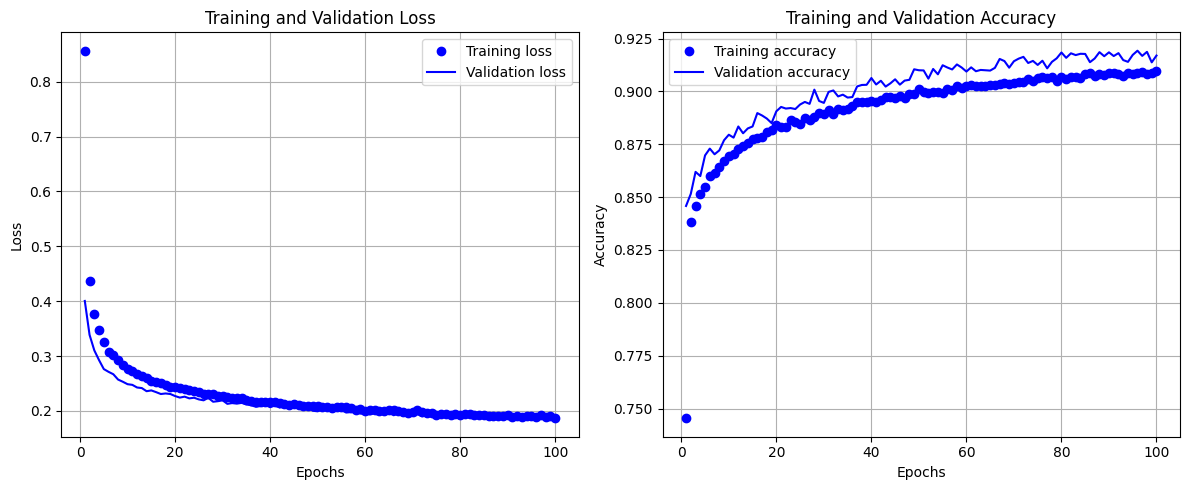

Training history plots generated.


In [20]:
# Plotting training & validation loss and accuracy
print("\nPlotting training history...")

# Get the metrics from the history object
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history plots generated.")


Evaluating model on the test set...


2025-06-18 04:57:01.770303: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 234589312 exceeds 10% of free system memory.


409/409 - 1s - 3ms/step - accuracy: 0.9127 - loss: 0.1907
Test Loss: 0.1907
Test Accuracy: 0.9127
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

          AO       0.96      1.00      0.98        46
          BD       0.00      0.00      0.00         0
          BE       0.32      1.00      0.48         6
          BR       1.00      1.00      1.00        10
          CA       0.94      0.97      0.95      1133
          CD       0.99      0.89      0.94       509
          CH       0.60      1.00      0.75         6
          CL       1.00      1.00      1.00         1
          CM       1.00      1.00      1.00        28
          CO       1.00      1.00      1.00         8
          ES       0.92      0.79      0.85       232
          FR       0.70      1.00      0.82         7
          GB       0.88      0.98      0.93      1669
          GH       1.00      0.96      0.98       163
          HU  

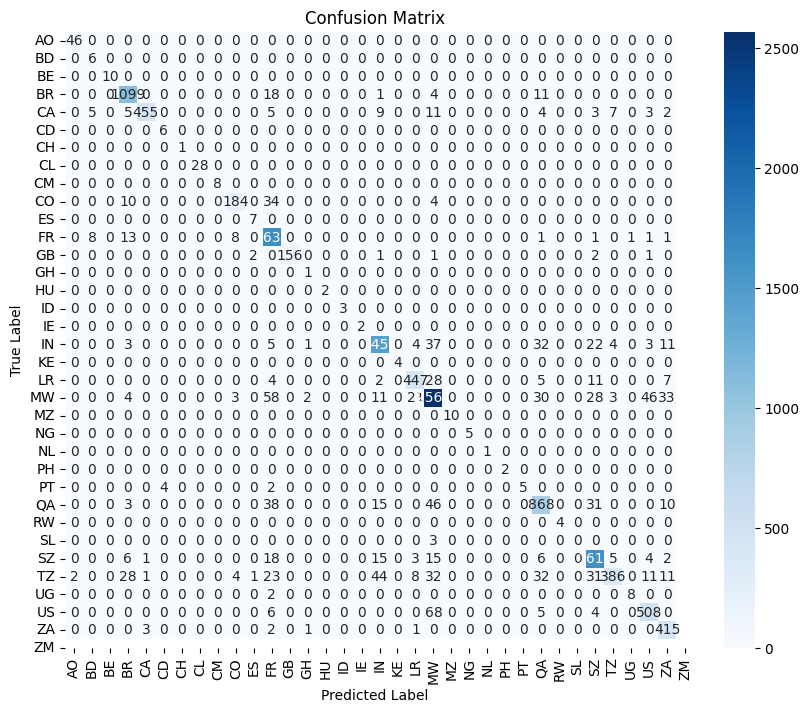

In [21]:
# Evaluate the model on the test set
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_encoded, verbose=2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# You can also make predictions and view a classification report

# Get predicted probabilities for the test set
y_pred_probs = model.predict(X_test_processed)
# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Generate classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_true=y_test_encoded,
                            y_pred=y_pred_labels,
                            labels=np.arange(len(label_encoder.classes_)), # All possible integer labels (0 to num_classes-1)
                            target_names=label_encoder.classes_,           # The corresponding string names
                            zero_division=0 # 'warn' or '0' to handle classes with no true samples or no predictions
                           ))

# Generate confusion matrix
print("\nConfusion Matrix on Test Set:")
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)
print(conf_matrix)

# Optional: Plot confusion matrix for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# --- Prepare data for SHAP ---
# SHAP explainers often work best with NumPy arrays.
# X_test_processed is already a NumPy array (or converted to one).

# Ensure the best model is loaded for explanation
# If your model variable 'model' is still the trained one, you can skip loading.
# Otherwise, load the best model saved by ModelCheckpoint:
try:
    # Attempt to load the best model if it was saved as .keras format
    loaded_model = tf.keras.models.load_model('best_deep_earth_sentinel_model.keras')
    print("Loaded the best trained model for SHAP explanations.")
except Exception as e:
    print(f"Could not load best_deep_sentinel_model.keras: {e}. Using the 'model' variable if it's already trained.")
    # Fallback to the 'model' object if it's already trained in memory
    loaded_model = model


Loaded the best trained model for SHAP explanations.


In [23]:
# For performance, especially if X_test_processed is very large,
# we might explain a subset of the test data.
# Let's use a sample of 1000 instances from the test set for SHAP explanation.
# Adjust this number based on your computational resources and desired depth of explanation.
X_shap_sample = X_test_processed[np.random.choice(X_test_processed.shape[0], 1000, replace=False)]

# Create a DeepExplainer
# The DeepExplainer requires a background dataset. For tabular data, a small sample of the training data
# is often used. We'll use a sample from X_train_processed.
X_train_background_sample = X_train_processed[np.random.choice(X_train_processed.shape[0], 100, replace=False)]

print(f"\nInitializing SHAP DeepExplainer (this may take a moment)...")
explainer = shap.DeepExplainer(loaded_model, X_train_background_sample)


Initializing SHAP DeepExplainer (this may take a moment)...


/home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(100, 4481))']
  warnings.warn(msg)


In [24]:
# Calculate SHAP values for the sample
# This step can be computationally intensive, especially with larger samples or models.
print(f"Calculating SHAP values for {X_shap_sample.shape[0]} samples from the test set...")
shap_values = explainer.shap_values(X_shap_sample)
print("SHAP values calculated.")

# shap_values will be a list of arrays, one for each output class.
# e.g., shap_values[0] for class 0, shap_values[1] for class 1, etc.
# The `label_encoder.classes_` contains the actual country names corresponding to these indices.

Calculating SHAP values for 1000 samples from the test set...


/home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(200, 4481))']
  warnings.warn(msg)
/home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1000, 4481))']
  warnings.warn(msg)


SHAP values calculated.


In [25]:
# Reconstruct feature names from the preprocessor
# This is crucial for interpretable plots
# The preprocessor's get_feature_names_out() method will give the final feature names.
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # For older scikit-learn versions
    # This part is more complex as it requires manual reconstruction
    # of one-hot encoded names. We'll simplify for now, assuming newer sklearn.
    print("Warning: get_feature_names_out() not found for preprocessor. Feature names might be generic.")
    numerical_feature_names = numerical_features.tolist()
    # Need to manually construct one-hot encoded names. This is a simplified approach.
    # It might not exactly match the order if ColumnTransformer reorders, but often works.
    categorical_ohe_names = []
    for i, col in enumerate(categorical_features):
        try:
            # Try to get categories from the fitted OneHotEncoder
            categories = preprocessor.named_transformers_['cat'].categories_[i]
            categorical_ohe_names.extend([f"{col}_{cat}" for cat in categories])
        except Exception:
            # Fallback if categories are not directly accessible
            categorical_ohe_names.extend([f"cat_{col}_ohe_{j}" for j in range(100)]) # Placeholder names
    feature_names = numerical_feature_names + categorical_ohe_names
    # If the number of generated feature names does not match X_shap_sample.shape[1],
    # the plot labels will be incorrect. This is a common challenge with complex preprocessors.
    # The `get_feature_names_out()` method introduced in scikit-learn 0.23+ is the most reliable way.
    if len(feature_names) != X_shap_sample.shape[1]:
        print("Warning: Feature names generated manually do not match feature count. Plot labels may be incorrect.")
        feature_names = [f'Feature {i}' for i in range(X_shap_sample.shape[1])]



Generating SHAP Summary Plot (Beeswarm)...


<Figure size 640x480 with 0 Axes>

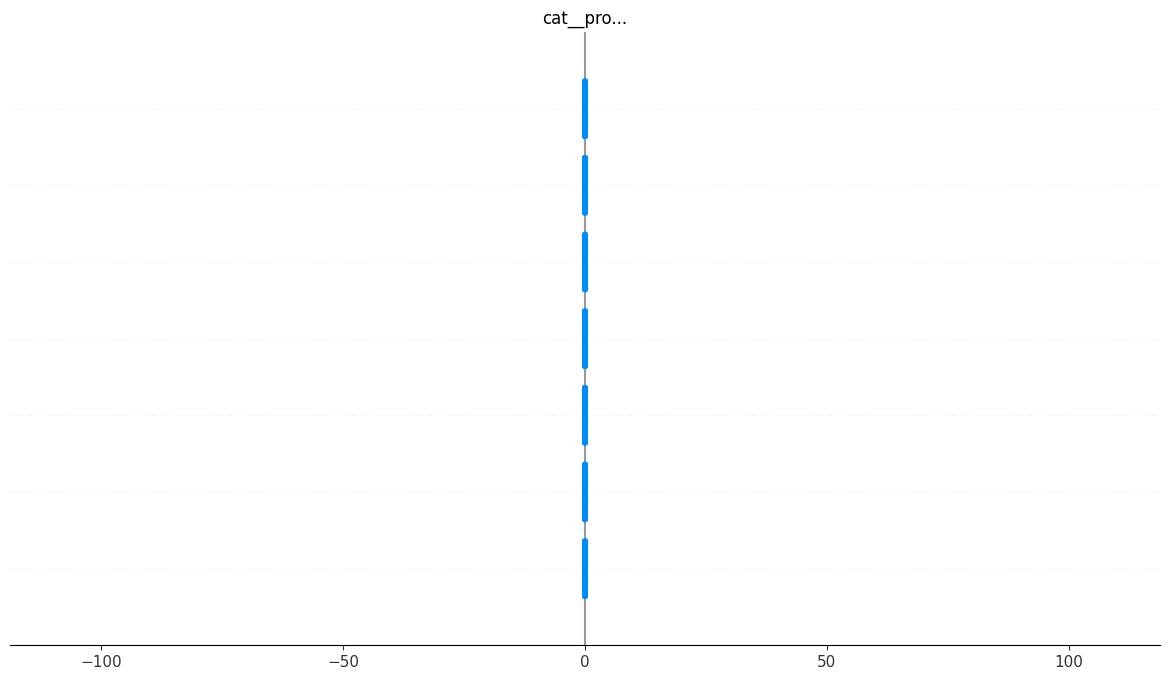

In [26]:
# Option 1: SHAP Summary Plot (Beeswarm) - Shows distribution of impact for each feature
# Each dot is an instance. Color indicates feature value (e.g., high/low).
# Position on x-axis indicates impact on prediction.
print("\nGenerating SHAP Summary Plot (Beeswarm)...")
shap.summary_plot(shap_values, X_shap_sample, feature_names=feature_names, plot_type="dot", class_names=label_encoder.classes_)
plt.show() # Display the plot


Generating SHAP Bar Plot (Overall Feature Importance)...


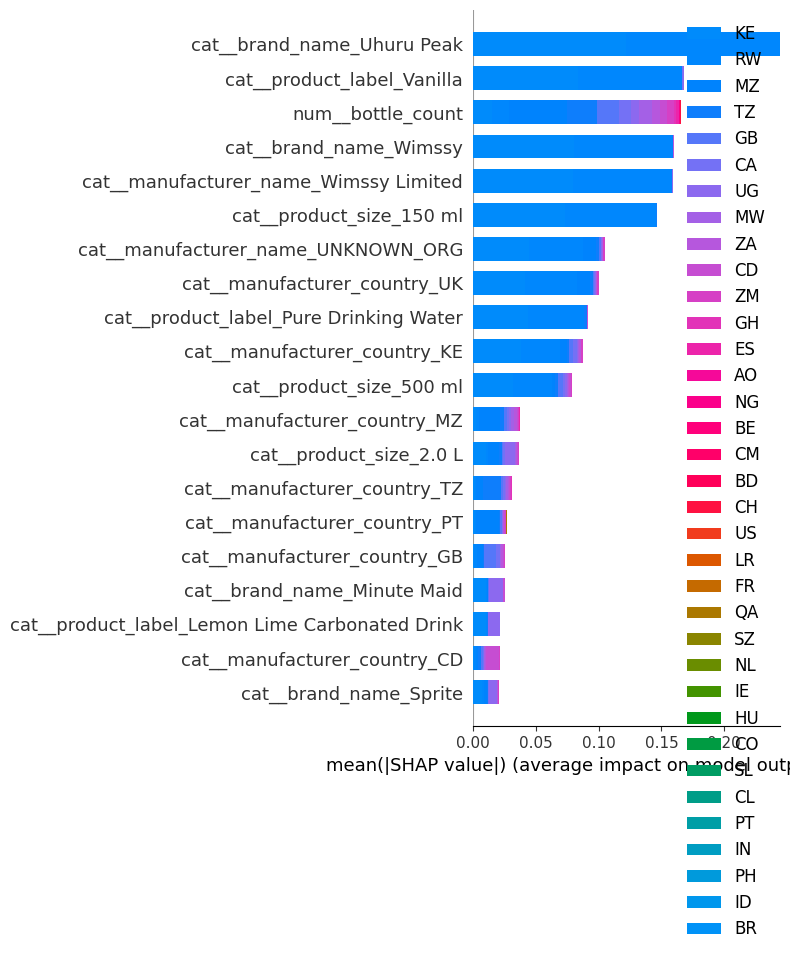

In [27]:
# Option 2: SHAP Bar Plot - Shows overall average magnitude of impact for each feature
print("\nGenerating SHAP Bar Plot (Overall Feature Importance)...")
shap.summary_plot(shap_values, X_shap_sample, feature_names=feature_names, plot_type="bar", class_names=label_encoder.classes_)
plt.show() # Display the plot